##### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import glob

from osgeo import gdal
from shapely import wkt

%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
import tifffile as sktif

import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *
import ujson as json
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


W1103 21:07:56.457997 139884189386560 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/metrics.py:103: The name tf.keras.metrics.cosine_proximity is deprecated. Please use tf.keras.losses.cosine_similarity instead.

W1103 21:07:56.531310 139884189386560 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/_keras_losses.py:104: The name tf.keras.losses.cosine is deprecated. Please use tf.keras.losses.cosine_similarity instead.



##### Files

In [2]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"
mask_dir.mkdir(exist_ok=True)

train_images_crops = data_dir/"train_crops"
train_mask_crops = data_dir/"mask_crops"

train_mask_crops.mkdir(exist_ok=True)
train_images_crops.mkdir(exist_ok=True)

In [3]:
(data_dir/"test"/"images").ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/test/images/test_pre_00909.png'),
 PosixPath('/media/wwymak/Storage/xView2/test/images/test_pre_00371.png'),
 PosixPath('/media/wwymak/Storage/xView2/test/images/test_pre_00824.png'),
 PosixPath('/media/wwymak/Storage/xView2/test/images/test_post_00082.png'),
 PosixPath('/media/wwymak/Storage/xView2/test/images/test_post_00294.png')]

The images are both pre and post diaster, with naming scheme `f"{place}-{disaster_type}_{id}_{pre/post}_disaster.png`

In [4]:
(data_dir/"train"/"images").ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/train/images/palu-tsunami_00000024_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/midwest-flooding_00000319_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/hurricane-matthew_00000005_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/hurricane-florence_00000392_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/train/images/socal-fire_00000669_post_disaster.png')]

In [5]:
(data_dir/"tier3"/"images").ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/tier3/images/tuscaloosa-tornado_00000049_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/tier3/images/pinery-bushfire_00000195_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/tier3/images/pinery-bushfire_00001695_pre_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/tier3/images/lower-puna-volcano_00000274_post_disaster.png'),
 PosixPath('/media/wwymak/Storage/xView2/tier3/images/nepal-flooding_00000115_pre_disaster.png')]

In [6]:
len((data_dir/"train"/"images").ls()), len((data_dir/"tier3"/"images").ls())

(5598, 12738)

Likewise labels (in json) are named similarly 

In [7]:
(data_dir/"train"/"labels").ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/train/labels/socal-fire_00000521_post_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/hurricane-michael_00000047_pre_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/socal-fire_00001003_pre_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/socal-fire_00000580_post_disaster.json'),
 PosixPath('/media/wwymak/Storage/xView2/train/labels/socal-fire_00000671_post_disaster.json')]

##### Mask construction

Parsing one label:

In [8]:
with open('/media/wwymak/Storage/xView2/tier3/labels/nepal-flooding_00000115_post_disaster.json', 'r') as f:
    test_label = json.load(f)

In [9]:
test_label

{'features': {'lng_lat': [{'properties': {'feature_type': 'building',
     'subtype': 'destroyed',
     'uid': '5fbe9eb1-28c6-4581-82e5-534267dee6d5'},
    'wkt': 'POLYGON ((83.4343414907799 26.62406599738632, 83.43439624164986 26.62407889730963, 83.4344049913701 26.62405201401211, 83.4343491737345 26.6240388541861, 83.4343414907799 26.62406599738632))'},
   {'properties': {'feature_type': 'building',
     'subtype': 'destroyed',
     'uid': '1a8c9a1e-6e1c-4f09-88cd-b39496df8fa0'},
    'wkt': 'POLYGON ((83.43480222541162 26.62414633601181, 83.43482715059774 26.6241217310791, 83.43479246526172 26.62409749360998, 83.43476608649497 26.62412212343119, 83.43480222541162 26.62414633601181))'},
   {'properties': {'feature_type': 'building',
     'subtype': 'un-classified',
     'uid': '6370e97c-3dff-4a60-813b-653d53096b4c'},
    'wkt': 'POLYGON ((83.43493959576183 26.62417861668779, 83.43495501726764 26.62415156066483, 83.43491766018991 26.62413847782147, 83.43490515968203 26.62416613727285, 

(1024, 1024, 3)


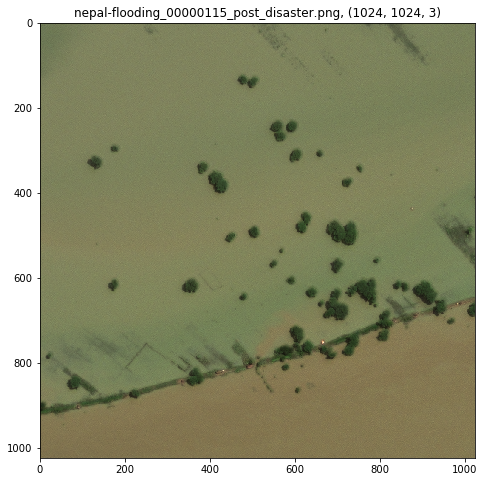

In [10]:
img_name = test_label['metadata']['img_name']
plt.figure(figsize=(8,8))
img = np.array(PIL.Image.open(data_dir/"tier3"/"images"/img_name))
plt.imshow(img);
plt.title(f"{img_name}, {img.shape}")
print(img.shape)

The xy field have the polygons in pixels

In [22]:
test_label['features']['xy']

[{'properties': {'feature_type': 'building',
   'subtype': 'destroyed',
   'uid': '5fbe9eb1-28c6-4581-82e5-534267dee6d5'},
  'wkt': 'POLYGON ((414.0515742108868 818.548670209474, 425.5231513564337 815.3067027555431, 427.4856218791386 821.5700722993338, 415.7905681311369 824.8772125010562, 414.0515742108868 818.548670209474))'},
 {'properties': {'feature_type': 'building',
   'subtype': 'destroyed',
   'uid': '1a8c9a1e-6e1c-4f09-88cd-b39496df8fa0'},
  'wkt': 'POLYGON ((510.7120603974473 797.8776274993739, 516.0705248274829 803.5422898962016, 508.8748725952265 809.3600512763015, 503.2102101988925 803.6953888794739, 510.7120603974473 797.8776274993739))'},
 {'properties': {'feature_type': 'building',
   'subtype': 'un-classified',
   'uid': '6370e97c-3dff-4a60-813b-653d53096b4c'},
  'wkt': 'POLYGON ((539.4946693294264 789.7633813623132, 542.8628469710154 796.0404396951836, 535.0547988009935 799.2555183527628, 532.2990170988929 792.8253610385891, 539.4946693294264 789.7633813623132))'},
 {

whereas the lng_lat field has the polygons in geocoords

In [18]:
test_label['features']['lng_lat']

[{'properties': {'feature_type': 'building',
   'uid': '5fbe9eb1-28c6-4581-82e5-534267dee6d5'},
  'wkt': 'POLYGON ((83.43434149076914 26.62406599739115, 83.43434917372375 26.62403885419094, 83.43440499135934 26.62405201401694, 83.43439624163911 26.62407889731446, 83.43434149076914 26.62406599739115))'},
 {'properties': {'feature_type': 'building',
   'uid': '1a8c9a1e-6e1c-4f09-88cd-b39496df8fa0'},
  'wkt': 'POLYGON ((83.43480222540084 26.62414633601665, 83.4347660864842 26.62412212343602, 83.43479246525095 26.62409749361482, 83.43482715058697 26.62412173108394, 83.43480222540084 26.62414633601665))'},
 {'properties': {'feature_type': 'building',
   'uid': '6370e97c-3dff-4a60-813b-653d53096b4c'},
  'wkt': 'POLYGON ((83.43493959575106 26.62417861669262, 83.43490515967126 26.62416613727768, 83.43491766017914 26.62413847782631, 83.43495501725687 26.62415156066967, 83.43493959575106 26.62417861669262))'},
 {'properties': {'feature_type': 'building',
   'uid': '7ce18618-1610-4377-b026-157ff0

In [11]:
def parse_json(label_json):
    df_xy =  pd.DataFrame([{'id':x['properties']['uid'], 'feature':x['properties']['feature_type'],
      'damage':x['properties'].get('subtype', 'no-damage'),
      'geometry_pixel':x['wkt']} for x in label_json['features']['xy']])
    df_lnglat = pd.DataFrame([{'id':x['properties']['uid'] ,'geometry_lnglat':x['wkt'],} for x in label_json['features']['lng_lat']])
    if len(df_xy) == 0:
        return
    df_xy.set_index('id', inplace=True)

    df_xy['damage_cls']= df_xy['damage'].map({
        'no-damage':1, 'minor-damage':2, 'major-damage':3, 'destroyed':4, 'un-classified':5
    })
    df_xy.geometry_pixel = df_xy.geometry_pixel.apply(wkt.loads)
    df_lnglat.set_index('id', inplace=True)
    label_df = df_xy.merge(df_lnglat['geometry_lnglat'], left_index=True, right_index=True)
    
    label_gdf = gpd.GeoDataFrame(label_df, geometry='geometry_pixel')
    label_gdf['centroid'] = label_gdf.geometry_pixel.centroid
    return label_gdf



In [12]:
label_gdf = parse_json(test_label)

In [13]:
label_gdf.head()

,feature,damage,geometry_pixel,damage_cls,geometry_lnglat,centroid
id,,,,,,
5fbe9eb1-28c6-4581-82e5-534267dee6d5,building,destroyed,"POLYGON ((414.0515742108868 818.548670209474, ...",4,"POLYGON ((83.4343414907799 26.62406599738632, ...",POINT (420.7154289571009 820.0858912063098)
1a8c9a1e-6e1c-4f09-88cd-b39496df8fa0,building,destroyed,"POLYGON ((510.7120603974473 797.8776274993739,...",4,"POLYGON ((83.43480222541162 26.62414633601181,...",POINT (509.6913031163605 803.6194480829027)
6370e97c-3dff-4a60-813b-653d53096b4c,building,un-classified,"POLYGON ((539.4946693294264 789.7633813623132,...",5,"POLYGON ((83.43493959576183 26.62417861668779,...",POINT (537.4556991332049 794.5079461235471)
7ce18618-1610-4377-b026-157ff057e982,building,destroyed,"POLYGON ((658.1454878038199 748.663465058232, ...",4,"POLYGON ((83.4355065718093 26.62434432826872, ...",POINT (662.4499784360601 750.1617079177953)
c60296ff-80f3-4069-95b6-fe9a8f8380c4,building,destroyed,"POLYGON ((959.943785213649 731.7290404088239, ...",4,"POLYGON ((83.43694079756837 26.62439203033719,...",POINT (958.6167121350931 736.1066917773886)


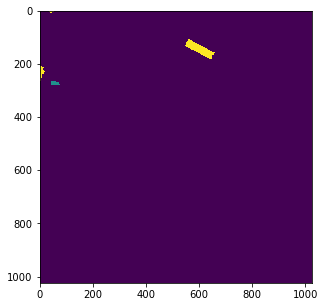

In [25]:
fp_mask = sol.vector.mask.footprint_mask(df=parse_json(test_label),geom_col='geometry_pixel',
                                         burn_field='damage_cls', shape=(1024,1024))
f, ax = plt.subplots(figsize=(5,5))
plt.imshow(fp_mask/4 * 255)

test_mask= sol.

Let's try to get a really good localisation segmentation first

In [3]:
def create_mask_pre_disaster(json_file):
    with open(data_dir/"train"/"labels"/json_file, 'r') as f:
        label = json.load(f)
    df = parse_json(label)
    if df is None or len(df) == 0:
        return
    fp_mask = sol.vector.mask.footprint_mask(df=parse_json(label),geom_col='geometry_pixel',
                                         burn_field='damage_cls', shape=(1024,1024))
    PIL.Image.fromarray(fp_mask).save(mask_dir/(json_file.replace('.json', '.png')))

In [25]:
# test mask creation
create_mask('socal-fire_00000521_post_disaster.json')
create_mask('socal-fire_00000521_pre_disaster.json')
test_mask_pre = PIL.Image.open(mask_dir/"socal-fire_00000521_pre_disaster.png")
test_mask_post = PIL.Image.open(mask_dir/"socal-fire_00000521_post_disaster.png")

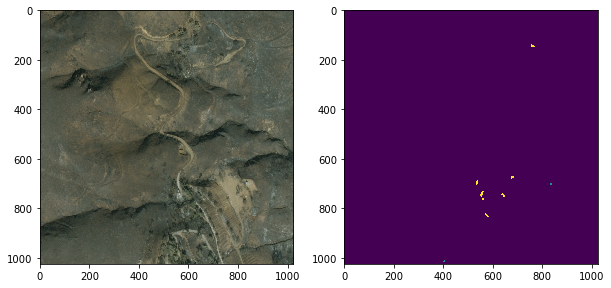

In [47]:
f, ax = plt.subplots(1,2,figsize=(10,5))
axs = ax.ravel()
axs[1].imshow(np.array(test_mask_post)/4 * 255)
axs[0].imshow(np.array(PIL.Image.open(data_dir/"train"/"images"/"socal-fire_00000521_post_disaster.png")))

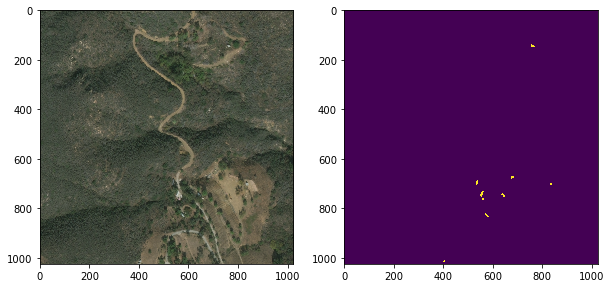

In [48]:
f, ax = plt.subplots(1,2,figsize=(10,5))
axs = ax.ravel()
axs[1].imshow(np.array(test_mask_pre)/4 * 255)
axs[0].imshow(np.array(PIL.Image.open(data_dir/"train"/"images"/"socal-fire_00000521_pre_disaster.png")))

Zooming into the houses:

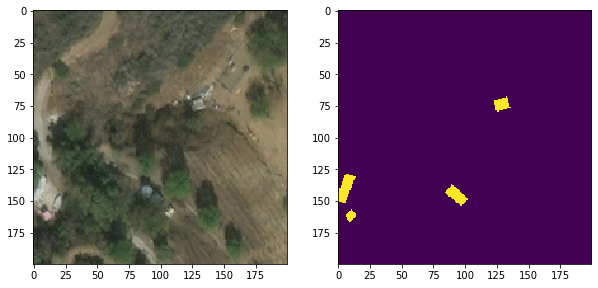

In [9]:
f, ax = plt.subplots(1,2,figsize=(10,5))
axs = ax.ravel()
axs[1].imshow(np.array(test_mask_pre)[600:800, 550:750]/4 * 255)
axs[0].imshow(np.array(PIL.Image.open(data_dir/"train"/"images"/"socal-fire_00000521_pre_disaster.png"))[600:800, 550:750])

##### A very non optimal way of creating crops...
As we can see, the buildings could be very tiny, and we might need to be clever about training the net/ mask creation. (e.g. train only on patches with buildings). One possible strategy: for each polygon, select a 128 patch roughly centered on the polygon

In [113]:
def create_crops(label_gdf, image_filename):
    crop_size = 256
    image = np.array(PIL.Image.open(data_dir/"train"/"images"/image_filename))
    x1= (label_gdf.geometry_pixel.centroid.x - crop_size /2 + 
         np.random.rand() * crop_size /2).astype(int).clip(lower=0, upper=(image.shape[0] - crop_size-1))

    y1 = (label_gdf.geometry_pixel.centroid.y - crop_size /2 +
          np.random.rand() * crop_size /2).astype(int).clip(lower=0, upper=(image.shape[0] - crop_size-1))
    x2 = x1 + crop_size
    y2 = y1 +crop_size
    crops_coords = list(zip(x1,x2,y1,y2))
    fp_mask = sol.vector.mask.footprint_mask(df=label_gdf,geom_col='geometry_pixel',
                                         burn_field='damage_cls', shape=(1024,1024))
    
    mask_crops = [fp_mask[y1:y2,x1:x2] for (x1,x2,y1,y2) in crops_coords]
    image_crops = [image[y1:y2,x1:x2] for (x1,x2,y1,y2) in crops_coords]
    ids = label_gdf.index.to_list()
    return list(zip(ids, image_crops, mask_crops))

In [102]:
def save_crop(id, img_crop, mask_crop):
    PIL.Image.fromarray(img_crop).save(train_images_crops / f"{id}.png")
    PIL.Image.fromarray(mask_crop).save(train_mask_crops / f"{id}.png")

In [103]:
#DONT USE THIS -- too slow and too many duplicates
def mask_pipeline(json_file):
    with open(data_dir/"train"/"labels"/json_file, 'r') as f:
        label = json.load(f)
        image_filename = label['metadata']['img_name']
        
    label_gdf = parse_json(label)
    if label_gdf is None:
        return 
    crops_output = create_crops(label_gdf, image_filename)
    if len(crops_output) == 0:
        return
    [save_crop(id, img_crop, mask_crop) for (id, img_crop, mask_crop) in crops_output]

In [99]:
mask_pipeline('socal-fire_00000521_post_disaster.json')

id
166f2a97-ff53-412a-9aab-af1dcf20cb6d    POLYGON ((754.5288621132306 138.9123260108159,...
b0d57694-6c36-4f73-9dfb-e8d75256a99c    POLYGON ((535.9465412525005 683.4002946073559,...
924a44c0-2b43-47ab-8d36-429e72fadfb9    POLYGON ((683.1720737540153 668.2224046560526,...
90fc8124-75a7-494b-b416-3ffa50543c64    POLYGON ((555.9307630141403 728.4280347892744,...
52480ab9-db79-4038-b38f-30db3cf664a2    POLYGON ((639.9150873997751 737.0288390931488,...
106d0969-155c-43e7-a033-7672b282c92a    POLYGON ((834.9509732418124 696.0485362302222,...
31dd2c16-d688-4f7d-ac2c-386cb91e28a4    POLYGON ((572.4218057172543 818.2077366215755,...
ded4e585-45f1-42ca-8200-779c71035b00    POLYGON ((560.7659193345396 756.9755971758364,...
e1521720-5d85-4595-8b79-55db7c4310b4    POLYGON ((403.9460085738816 1007.603083481029,...
Name: geometry_pixel, dtype: object


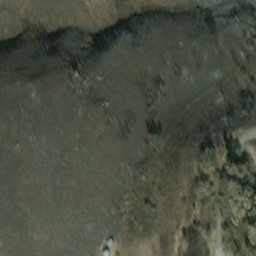

In [80]:
PIL.Image.open(train_images_crops / f"e1521720-5d85-4595-8b79-55db7c4310b4.png")

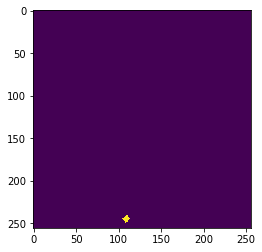

In [81]:
plt.imshow(np.array(PIL.Image.open(train_mask_crops / f"e1521720-5d85-4595-8b79-55db7c4310b4.png"))/4 * 255)

##### A smarter way of going about things

(more or less reusing the creating crops function in spacenet roads project)

In [133]:
# %time _=Parallel(n_jobs=16)(delayed(create_mask)(fname.name) for fname in (data_dir/"train"/"labels").ls())
# from tqdm import tqdm

_= [create_mask(fname.name) for fname in tqdm((data_dir/"train"/"labels").ls())]




  0%|          | 0/5598 [00:00<?, ?it/s]


  0%|          | 9/5598 [00:00<01:08, 81.51it/s]


  0%|          | 18/5598 [00:00<01:07, 82.99it/s]


  0%|          | 24/5598 [00:00<01:20, 69.57it/s]


  1%|          | 31/5598 [00:00<01:20, 69.52it/s]


  1%|          | 37/5598 [00:00<01:26, 64.48it/s]


  1%|          | 43/5598 [00:00<01:29, 61.80it/s]


  1%|          | 51/5598 [00:00<01:25, 65.04it/s]


  1%|          | 58/5598 [00:00<01:40, 55.12it/s]


  1%|          | 64/5598 [00:01<01:39, 55.75it/s]


  1%|▏         | 75/5598 [00:01<01:25, 64.83it/s]


  1%|▏         | 83/5598 [00:01<01:21, 67.62it/s]


  2%|▏         | 91/5598 [00:01<01:24, 64.82it/s]


  2%|▏         | 98/5598 [00:01<01:30, 60.62it/s]


  2%|▏         | 105/5598 [00:01<01:37, 56.51it/s]


  2%|▏         | 114/5598 [00:01<01:27, 62.84it/s]


  2%|▏         | 124/5598 [00:01<01:20, 68.34it/s]


  2%|▏         | 132/5598 [00:02<01:25, 64.29it/s]


  2%|▏         | 139/5598 [00:02<01:36, 56.74it/s]


  3%|▎        

 36%|███▌      | 2003/5598 [00:32<00:55, 64.61it/s]


 36%|███▌      | 2010/5598 [00:32<00:57, 62.91it/s]


 36%|███▌      | 2017/5598 [00:32<00:56, 62.83it/s]


 36%|███▌      | 2025/5598 [00:32<00:56, 62.96it/s]


 36%|███▋      | 2034/5598 [00:33<00:52, 68.15it/s]


 36%|███▋      | 2042/5598 [00:33<00:51, 69.68it/s]


 37%|███▋      | 2050/5598 [00:33<00:50, 69.87it/s]


 37%|███▋      | 2058/5598 [00:33<00:57, 61.59it/s]


 37%|███▋      | 2067/5598 [00:33<00:52, 67.44it/s]


 37%|███▋      | 2075/5598 [00:33<01:00, 58.62it/s]


 37%|███▋      | 2082/5598 [00:33<01:00, 58.19it/s]


 37%|███▋      | 2090/5598 [00:33<00:56, 61.92it/s]


 37%|███▋      | 2097/5598 [00:34<00:54, 63.95it/s]


 38%|███▊      | 2104/5598 [00:34<00:57, 60.35it/s]


 38%|███▊      | 2111/5598 [00:34<01:01, 56.71it/s]


 38%|███▊      | 2117/5598 [00:34<01:01, 56.60it/s]


 38%|███▊      | 2124/5598 [00:34<00:59, 58.21it/s]


 38%|███▊      | 2134/5598 [00:34<00:52, 65.69it/s]


 38%|███▊      | 2142/5598 [

 69%|██████▊   | 3847/5598 [01:06<00:29, 58.65it/s]


 69%|██████▉   | 3855/5598 [01:06<00:32, 53.63it/s]


 69%|██████▉   | 3862/5598 [01:06<00:34, 50.76it/s]


 69%|██████▉   | 3869/5598 [01:06<00:31, 55.24it/s]


 69%|██████▉   | 3876/5598 [01:06<00:34, 49.23it/s]


 69%|██████▉   | 3882/5598 [01:06<00:39, 43.36it/s]


 69%|██████▉   | 3887/5598 [01:07<00:40, 42.23it/s]


 70%|██████▉   | 3895/5598 [01:07<00:35, 47.97it/s]


 70%|██████▉   | 3901/5598 [01:07<00:36, 46.75it/s]


 70%|██████▉   | 3908/5598 [01:07<00:33, 50.64it/s]


 70%|██████▉   | 3914/5598 [01:07<00:33, 50.61it/s]


 70%|███████   | 3920/5598 [01:07<00:34, 48.87it/s]


 70%|███████   | 3926/5598 [01:07<00:33, 49.38it/s]


 70%|███████   | 3932/5598 [01:08<00:45, 36.82it/s]


 70%|███████   | 3939/5598 [01:08<00:38, 42.76it/s]


 71%|███████   | 3948/5598 [01:08<00:51, 32.12it/s]


 71%|███████   | 3954/5598 [01:08<00:46, 35.68it/s]


 71%|███████   | 3962/5598 [01:08<00:38, 42.21it/s]


 71%|███████   | 3968/5598 [

 99%|█████████▉| 5538/5598 [01:41<00:01, 51.08it/s]


 99%|█████████▉| 5544/5598 [01:41<00:01, 48.03it/s]


 99%|█████████▉| 5550/5598 [01:41<00:00, 49.06it/s]


 99%|█████████▉| 5558/5598 [01:41<00:00, 55.48it/s]


 99%|█████████▉| 5565/5598 [01:41<00:00, 54.04it/s]


100%|█████████▉| 5571/5598 [01:41<00:00, 54.64it/s]


100%|█████████▉| 5577/5598 [01:41<00:00, 53.85it/s]


100%|█████████▉| 5583/5598 [01:41<00:00, 50.58it/s]


100%|█████████▉| 5594/5598 [01:42<00:00, 58.52it/s]


100%|██████████| 5598/5598 [01:42<00:00, 54.84it/s]

In [6]:
def create_small_tiles(img_filepath, mask_filepath, im_id, save_dir_rgb, save_dir_mask):
    if not mask_filepath.exists():
        return
    img_rgb = PIL.Image.open(img_filepath)
    mask_im = PIL.Image.open(mask_filepath)

#     mask = np.array(mask_im)
    if mask_im.getextrema()[1] == 0:
        return
    
#     box = left, upper, right, and lower pixe

    boxes = [
        (0, 0, 512, 512),
        (0, 256, 512, 768),
        (0, 512,512, 1024),
        (256, 0, 768, 512),
        (256, 256, 768, 768),
        (256, 512, 768, 1024),
        (512,0, 1024, 512),
        (512,256, 1024, 768),
        (512,512,1024,1024)
    ]
    
    mask_crops = [mask_im.crop(box) for box in boxes]
    im_crops = [img_rgb.crop(box) for box in boxes]
    

    img_names = [save_dir_rgb/ f"rgb_{im_id}_{i}.png" for i in range(4)]
    mask_names = [save_dir_mask/ f"mask_{im_id}_{i}.png" for i in range(4)]
    
    for i, (mask_crop, im_crop) in enumerate(zip(mask_crops, im_crops)):
        mask_max = mask_crop.getextrema()[1]
        if mask_max > 0:
            mask_crop.save(save_dir_mask/ f"mask_{im_id}_{i}.png")
            im_crop.save(save_dir_rgb/ f"rgb_{im_id}_{i}.png")
            
 

Other than segmentation, it would be interesting to see if we can tell what sort of disaster it is from the satellite images...

In [8]:
%%time 
create_tile = partial(create_small_tiles, save_dir_rgb=train_images_crops,save_dir_mask=train_mask_crops)

img_filepaths = (data_dir/"train"/"images").ls()
mask_filepaths = [mask_dir / f.name for f in img_filepaths]
img_ids =  [f.name.replace('png', '') for f in img_filepaths]
# [create_tile(img_filepath, mask_filepath, im_id) for (img_filepath, mask_filepath, im_id) in zip(img_filepaths, mask_filepaths, img_ids )]
_=Parallel(n_jobs=14)(delayed(create_tile)(img_filepath, mask_filepath, im_id) \
        for (img_filepath, mask_filepath, im_id) in zip(img_filepaths, mask_filepaths, img_ids ))
# from tqdm import tqdm

CPU times: user 13.8 s, sys: 326 ms, total: 14.2 s
Wall time: 4min 8s


In [15]:
%%time
metadata = []
for f in (data_dir/"train"/"labels").ls():
    with open(f, 'r') as jsonfile:
        doc = json.load(jsonfile)
        metadata.append(doc['metadata'][''])
metadata_df = pd.DataFrame(metadata)

CPU times: user 16.9 ms, sys: 0 ns, total: 16.9 ms
Wall time: 28.6 ms


In [16]:
metadata_df.head()

,sensor,provider_asset_type,gsd,capture_date,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,disaster,disaster_type,catalog_id,original_width,original_height,width,height,id,img_name
0,WORLDVIEW02,WORLDVIEW02,2.570075,2018-11-14T18:42:58.000Z,32.674200,0.643838,163.31218,35.885086,334.12890,socal-fire,fire,103001008513F200,1024,1024,1024,1024,MjU4MDE3OA.vigoXx_P7tlDKfvwJzQ1nrrupIc,socal-fire_00000521_post_disaster.png
1,WORLDVIEW02,WORLDVIEW02,2.066485,2017-11-29T16:28:19.000Z,19.816387,0.516751,162.03100,35.949000,285.76627,hurricane-michael,wind,1030010075CC2C00,1024,1024,1024,1024,MjE5Nzc5MA.m3CJXOd-mkKwPckmnN2HXJrZ8dQ,hurricane-michael_00000047_pre_disaster.png
2,WORLDVIEW02,WORLDVIEW02,1.989495,2018-10-23T18:51:02.000Z,15.396526,0.498313,163.75761,42.667400,333.27460,socal-fire,fire,1030010088D86900,1024,1024,1024,1024,MjU3NzI5NA.xXAyToVXpsDLRlmiil7ERxQfsao,socal-fire_00001003_pre_disaster.png
3,WORLDVIEW02,WORLDVIEW02,2.570075,2018-11-14T18:42:58.000Z,32.674200,0.643838,163.31218,35.885086,334.12890,socal-fire,fire,103001008513F200,1024,1024,1024,1024,MjU4MDIzOA.yYVJwy8u7xcp4JFTijIVJloYFYw,socal-fire_00000580_post_disaster.png
4,WORLDVIEW02,WORLDVIEW02,2.570075,2018-11-14T18:42:58.000Z,32.674200,0.643838,163.31218,35.885086,334.12890,socal-fire,fire,103001008513F200,1024,1024,1024,1024,MjU4MDMzMA.FxeSXSVYWtuXyCXeLboTXawiZX0,socal-fire_00000671_post_disaster.png


In [17]:
metadata_df.to_csv(data_dir/"train"/"metdata.csv",  index=False)

#### Image differences

In [14]:
pre_image = np.array(PIL.Image.open(data_dir/"train"/"images"/"socal-fire_00000521_pre_disaster.png"))[600:800, 550:750]
post_image = np.array(PIL.Image.open(data_dir/"train"/"images"/"socal-fire_00000521_post_disaster.png"))[600:800, 550:750]

In [23]:
pre_mean = pre_image.mean(axis=(0,1))
pre_std = pre_image.std(axis=(0,1))

post_mean = post_image.mean(axis=(0,1))
post_std = post_image.std(axis=(0,1))

pre_image_normed = (pre_image - pre_mean)/pre_std
post_image_normed = (post_image - post_mean)/post_std

In [22]:
pre_image.mean(axis=(0,1))

array([93.1345  , 92.817425, 73.250475])

W1005 22:06:16.833781 140480370845504 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


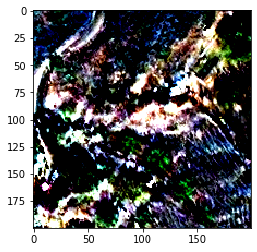

In [24]:
diff = pre_image_normed - post_image_normed
plt.imshow(diff)

In [27]:
pre_mask =  np.array(PIL.Image.open(mask_dir/"socal-fire_00000521_pre_disaster.png"))[600:800, 550:750]
np.unique(pre_mask)

array([0, 1], dtype=uint8)

W1005 22:09:25.517642 140480370845504 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


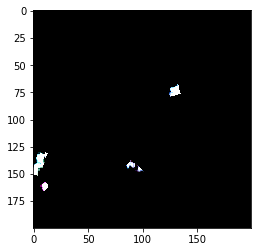

In [29]:
plt.imshow(diff * pre_mask[..., None])

In [34]:
(diff * pre_mask[..., None]).max()

6.042624789909778